In [1]:
%matplotlib inline
import os
import numpy as np

import readdy_learn.analyze.generate as generate
import readdy_learn.generate.generate_tools.kinetic_monte_carlo as kmc
import readdy_learn.analyze.basis as basis
import readdy_learn.analyze.sklearn as rlas
import readdy_learn.analyze.tools as tools
import readdy_learn.analyze.derivative as deriv
import readdy_learn.sample_tools as sample_tools

if True:
    import matplotlib as mpl
    mpl.rcParams['xtick.labelsize'] = 48
    mpl.rcParams['ytick.labelsize'] = 48

    mpl.rcParams['xtick.major.pad'] = 10
    mpl.rcParams['ytick.major.pad'] = 5

    mpl.rcParams['xtick.major.size'] = 12
    mpl.rcParams['xtick.major.width'] = 2
    mpl.rcParams['xtick.minor.size'] = 8
    mpl.rcParams['xtick.minor.width'] = 1

    mpl.rcParams['ytick.major.size'] = 14
    mpl.rcParams['ytick.major.width'] = 2
    mpl.rcParams['ytick.minor.size'] = 8
    mpl.rcParams['ytick.minor.width'] = 1

    mpl.rc('font',**{'size':48, 'family':'serif','serif':['Arial']})
    mpl.rc('text', usetex=True)
    mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

    mpl.rc('legend', fontsize=30)

    mpl.rcParams['figure.figsize'] = (15, 15)
import matplotlib.pyplot as plt

In [2]:
postfix = "new"

In [3]:
plot_concentrations_train_set_fname = 'cv_concentrations_train_{}.eps'.format(postfix)
plot_concentrations_test_set_fname = 'cv_concentrations_test_{}.eps'.format(postfix)
plot_score_curve_fname = 'cv_score_{}.eps'.format(postfix)
plot_expected_estimated_concentrations_fname = 'cv_expected_estimated_concentrations_{}.eps'.format(postfix)

In [4]:
if True:
    timestep = 1e-4
    n_steps=200
    n_species = 4
    tol=5e-6
    # interp_degree >= 0: interpolate with polynomials
    # interp_degree < 0: interpolate with curve fit (actual value has no influence)
    # interp_degree = 'pw_linear': piecewise linear interpolation of counts
    # interp_degree = 'SINDy': maybe this works, todo
    interp_degree='pw_linear'
    desired_rates = np.array([.02, .02, .01, 1e-4, 1e-4, 0,0,0,0,0, 0])
    train_initial_state = np.array([[70, 50, 30, 50]])
    n_gillespie_realizations = 20

    initial_coefficients_fname = 'initial_coefficients{}.npy'.format(postfix)
    lasso_coefficients_fname = 'lasso_coefficients{}.npy'.format(postfix)
    train_traj_counts_fname = 'train_traj_counts{}.npy'.format(postfix)
    test_traj_counts_fname = 'test_traj_counts{}.npy'.format(postfix)
    cv_results_fname = 'cv_results{}.npy'.format(postfix)

In [5]:
if False:
    timestep = 1e-4
    n_steps=270
    n_species = 4
    tol=5e-6
    # interp_degree >= 0: interpolate with polynomials
    # interp_degree < 0: interpolate with curve fit (actual value has no influence)
    # interp_degree = 'pw_linear': piecewise linear interpolation of counts
    # interp_degree = 'SINDy': maybe this works, todo
    interp_degree='pw_linear'
    desired_rates = np.array([.02, .02, .01, 1e-4, 1e-4, 0,0,0,0,0,0,0, 0])
    train_initial_state = np.array([[70, 50, 30, 50]])
    n_gillespie_realizations = 16

    initial_coefficients_fname = 'initial_coefficients_longer.npy'
    lasso_coefficients_fname = 'lasso_coefficients_longer.npy'
    train_traj_counts_fname = 'train_traj_counts_longer.npy'
    test_traj_counts_fname = 'test_traj_counts_longer.npy'
    cv_results_fname = 'cv_results_longer.npy'

In [6]:
def set_up_system(init_state):
    sys = kmc.ReactionDiffusionSystem(n_species=4, n_boxes=1, diffusivity=[[[0.]], [[0.]], [[0.]], [[0.]]],
                                      init_state=init_state, species_names=["A", "B", "C", "D"])
    sys.add_conversion("A", "D", np.array([desired_rates[0]]))
    sys.add_conversion("D", "A", np.array([desired_rates[1]]))
    sys.add_conversion("D", "B", np.array([desired_rates[2]]))
    sys.add_fusion("A", "B", "C", np.array([desired_rates[3]]))
    sys.add_fission("C", "D", "B", np.array([desired_rates[4]]))

    return sys

In [7]:
def get_bfc():
    bfc = basis.BasisFunctionConfiguration(n_species=n_species)
    bfc.add_conversion(0, 3)  # A -> D
    bfc.add_conversion(3, 0)  # D -> A
    bfc.add_conversion(3, 1)  # D -> B
    bfc.add_fusion(0, 1, 2) # A + B -> C
    bfc.add_fission(2, 3, 1) # C -> D + B
    
    bfc.add_conversion(0, 1) # A -> B, nope
    bfc.add_conversion(1, 0) # B -> A, nope
    bfc.add_conversion(2, 0) # C -> A, nope
    bfc.add_conversion(0, 2) # A -> C, nope
    bfc.add_fusion(0, 2, 3) # A + C -> D, nope
    bfc.add_fission(3, 0, 2) # D -> A + C, nope
    
    # bfc.add_fusion(0, 3, 2) # A + D -> C, nope
    # bfc.add_fission(2, 0, 1) # C -> A + B, nope
    # bfc.add_fission(2, 0, 2) # C -> A + C, nope
    
    assert bfc.n_basis_functions == len(desired_rates)
    return bfc

In [8]:
def get_train_traj():
    if not os.path.exists(train_traj_counts_fname):
        times, counts = generate.generate_averaged_kmc_counts(lambda: set_up_system(train_initial_state), n_steps, 
                                                          timestep, n_realizations=n_gillespie_realizations)
        np.save(train_traj_counts_fname, counts)
    else:
        counts = np.load(train_traj_counts_fname)
        times = np.linspace(0, float(counts.shape[0]) * float(timestep), num=counts.shape[0], endpoint=False)
    train_traj = tools.Trajectory(counts, timestep, interpolation_degree=interp_degree, verbose=False)
    train_traj.update()
    return train_traj
def get_test_traj():
    nmax=120
    init = [[np.random.randint(0, nmax), np.random.randint(0, 
                                                           nmax),  
             np.random.randint(0, nmax), np.random.randint(0, nmax)]]
    init = [[52, 42, 81, 7]]
    if not os.path.exists(test_traj_counts_fname):
        times, counts = generate.generate_averaged_kmc_counts(lambda: set_up_system(init), n_steps, 
                                                          timestep, n_realizations=n_gillespie_realizations)
        np.save(test_traj_counts_fname, counts)
    else:
        counts = np.load(test_traj_counts_fname)
        times = np.linspace(0, float(counts.shape[0]) * float(timestep), num=counts.shape[0], endpoint=False)
    test_traj = tools.Trajectory(counts, timestep, interpolation_degree=interp_degree, verbose=False)
    test_traj.update()
    return test_traj

In [9]:
def plot_results(traj, rates, title=None, outfile=None):
    from scipy.integrate import odeint
    bfc = get_bfc()
    def fun(data, _):
        theta = np.array([f(data) for f in bfc.functions])
        return np.matmul(rates, theta)
    def fun_reference(data, _):
        theta = np.array([f(data) for f in bfc.functions])
        return np.matmul(desired_rates, theta)
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
    # f.suptitle("least squares fit for full trajectory (not well-mixed in the last time steps)")
    xs = traj.times
    num_solution = odeint(fun, traj.counts[0], xs)
    reference_soln = odeint(fun_reference, traj.counts[0], xs)
    axes = [ax1, ax2, ax3, ax4]
    labels=["A", "B", "C", "D"]
    if title is not None:
        f.suptitle(title)
    for i in range(traj.n_species):
        axes[i].plot(xs, traj.counts[:,i], label='gillespie realization')
        axes[i].plot(xs, num_solution[:, i], label='estimated rates')
        axes[i].plot(xs, reference_soln[:, i], 'k--', label='original rates')
        axes[i].set_title("Concentration of %s particles over time" % labels[i])
        axes[i].legend()
        
    if outfile is not None:
        f.savefig(outfile)
    plt.show()

In [10]:
train_traj = get_train_traj()

[KMC] [2017-11-01 15:01:08] [INFO] Simulate for 200 steps
[KMC] [2017-11-01 15:01:08] [INFO] Simulate for 200 steps
[KMC] [2017-11-01 15:01:08] [INFO] Simulate for 200 steps
[KMC] [2017-11-01 15:01:08] [INFO] Simulate for 200 steps
[KMC] [2017-11-01 15:01:08] [INFO] Simulate for 200 steps
[KMC] [2017-11-01 15:01:08] [INFO] Simulate for 200 steps
[KMC] [2017-11-01 15:01:08] [INFO] Simulate for 200 steps
[KMC] [2017-11-01 15:01:08] [INFO] Simulate for 200 steps
[KMC] [2017-11-01 15:01:08] [INFO] got time step 0.0001 and n_frames 756446
[KMC] [2017-11-01 15:01:08] [INFO] got time step 0.0001 and n_frames 674725
[KMC] [2017-11-01 15:01:08] [INFO] got time step 0.0001 and n_frames 824147
[KMC] [2017-11-01 15:01:08] [INFO] got time step 0.0001 and n_frames 852104
[KMC] [2017-11-01 15:01:08] [INFO] got time step 0.0001 and n_frames 743735
[KMC] [2017-11-01 15:01:08] [INFO] got time step 0.0001 and n_frames 766459
[KMC] [2017-11-01 15:01:08] [INFO] got time step 0.0001 and n_frames 746121
[KMC

In [11]:
test_traj = get_test_traj()

[KMC] [2017-11-01 15:01:11] [INFO] Simulate for 200 steps
[KMC] [2017-11-01 15:01:11] [INFO] Simulate for 200 steps
[KMC] [2017-11-01 15:01:11] [INFO] Simulate for 200 steps
[KMC] [2017-11-01 15:01:11] [INFO] Simulate for 200 steps
[KMC] [2017-11-01 15:01:11] [INFO] Simulate for 200 steps
[KMC] [2017-11-01 15:01:11] [INFO] Simulate for 200 steps
[KMC] [2017-11-01 15:01:11] [INFO] Simulate for 200 steps
[KMC] [2017-11-01 15:01:11] [INFO] Simulate for 200 steps
[KMC] [2017-11-01 15:01:11] [INFO] got time step 0.0001 and n_frames 2827275
[KMC] [2017-11-01 15:01:11] [INFO] got time step 0.0001 and n_frames 2595463
[KMC] [2017-11-01 15:01:11] [INFO] got time step 0.0001 and n_frames 2507220
[KMC] [2017-11-01 15:01:11] [INFO] got time step 0.0001 and n_frames 2743583
[KMC] [2017-11-01 15:01:11] [INFO] got time step 0.0001 and n_frames 2389006
[KMC] [2017-11-01 15:01:11] [INFO] got time step 0.0001 and n_frames 3661168
[KMC] [2017-11-01 15:01:11] [INFO] got time step 0.0001 and n_frames 23647

In [12]:
# plot concentrations
system = set_up_system(train_initial_state)
suite = sample_tools.Suite.from_trajectory(train_traj, system, get_bfc())
#suite.plot_concentrations()
#
test_system = set_up_system([[52, 42, 81, 7]])
test_suite = sample_tools.Suite.from_trajectory(test_traj, test_system, get_bfc())
#test_suite.plot_concentrations()

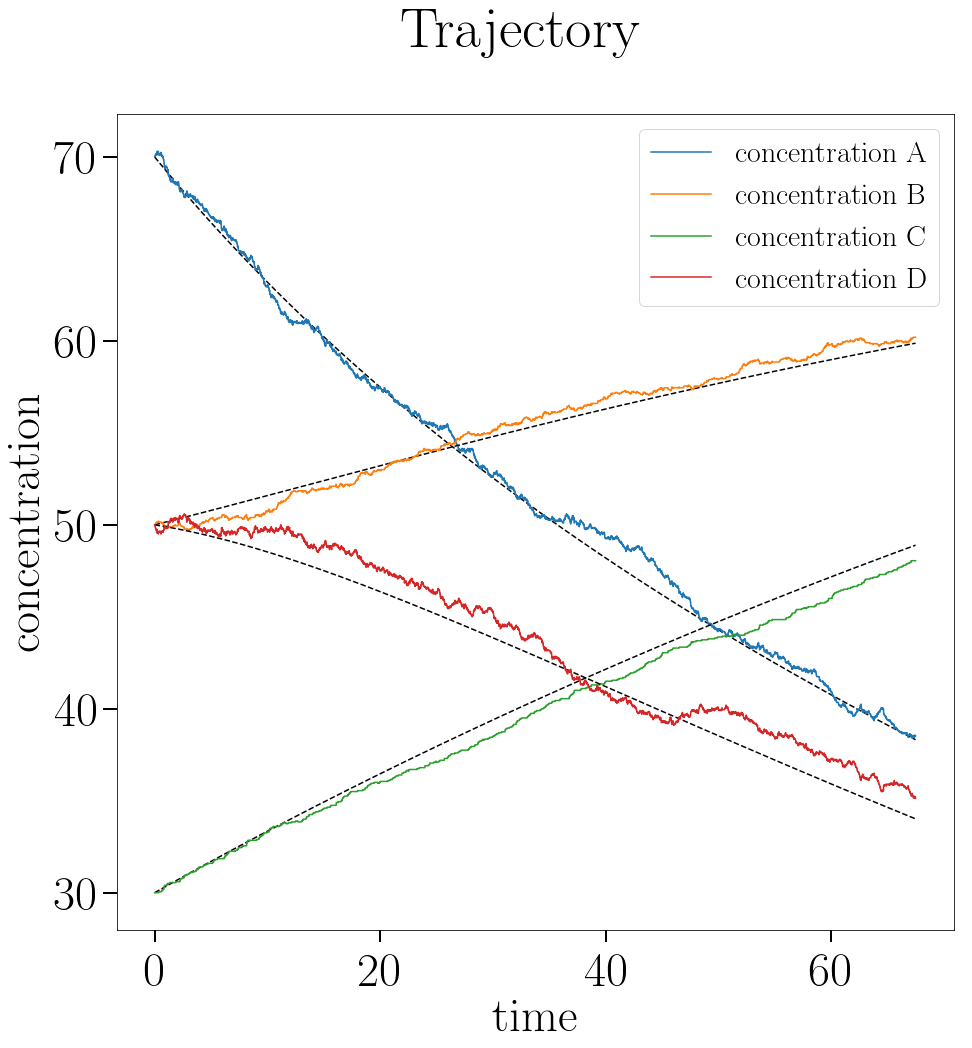

In [13]:
config = system.get_trajectory_config()
estimated = sample_tools.Suite.estimated_behavior(desired_rates, get_bfc(), train_traj.counts[0], train_traj.times)

fig, ax1 = plt.subplots(nrows=1, ncols=1)

fig.suptitle('Trajectory')
ax1.set_xlabel('time')
ax1.set_ylabel('concentration')
for t in config.types.keys():
    type_id = config.types[t]
    ax1.plot(train_traj.times, estimated[:, type_id], "k--")
    ax1.plot(train_traj.times, train_traj.counts[:, type_id], label="concentration " + t)
ax1.legend(loc="best")
fig.savefig(plot_concentrations_train_set_fname)

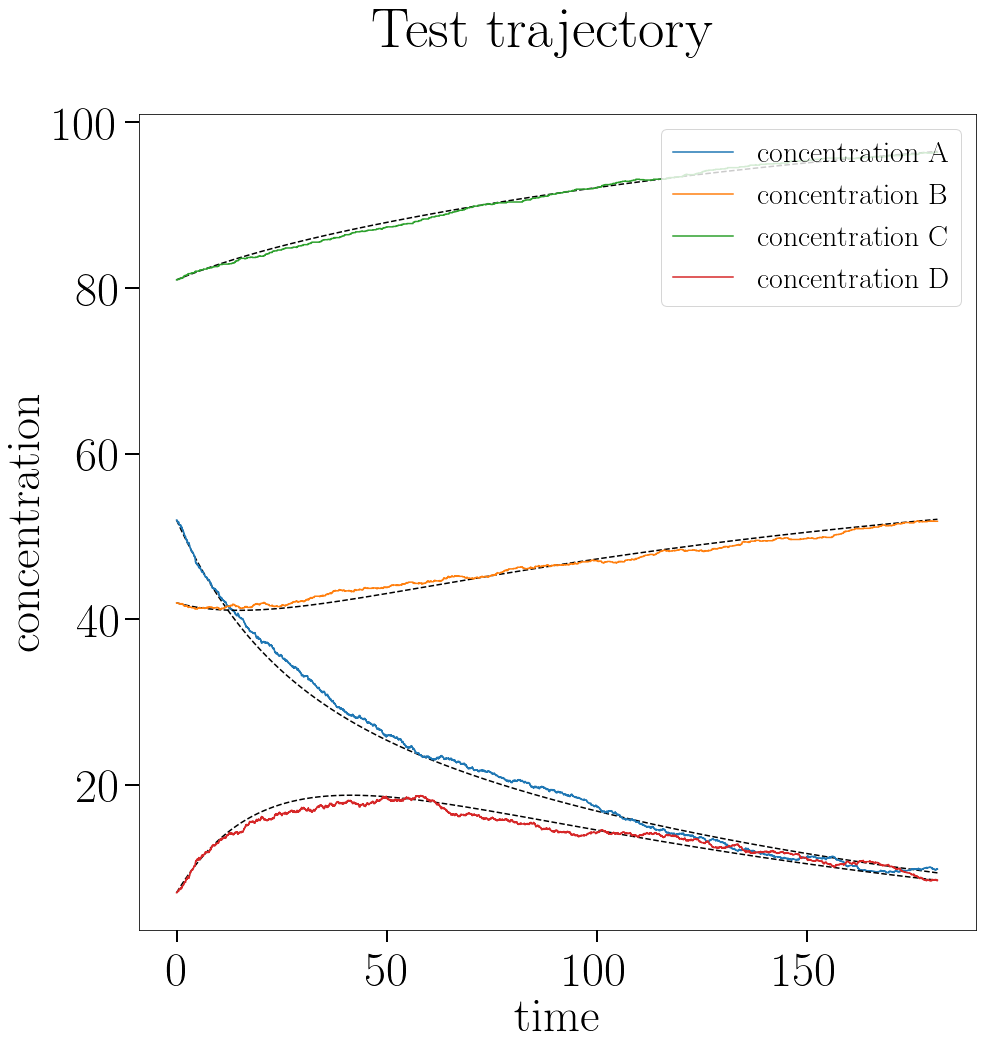

In [14]:
config = test_system.get_trajectory_config()
estimated = sample_tools.Suite.estimated_behavior(desired_rates, get_bfc(), test_traj.counts[0], test_traj.times)

fig, ax1 = plt.subplots(nrows=1, ncols=1)

fig.suptitle('Test trajectory')
ax1.set_xlabel('time')
ax1.set_ylabel('concentration')
for t in config.types.keys():
    type_id = config.types[t]
    ax1.plot(test_traj.times, estimated[:, type_id], "k--")
    ax1.plot(test_traj.times, test_traj.counts[:, type_id], label="concentration " + t)
ax1.legend(loc="best")
fig.savefig(plot_concentrations_test_set_fname)

In [15]:
estimator = suite.get_estimator(interp_degree=interp_degree)

In [16]:
if False:
    from scipy import interpolate
    from scipy import optimize
    traj = estimator.trajs[0]

    dt = traj.time_step
    X = np.linspace(0, 1, num=traj.n_time_steps) * dt

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,8))

    theta = estimator.get_theta(traj.counts)
    theta = np.transpose(theta, axes=(0, 2, 1))
    dx = theta.dot(desired_rates)

    for s in range(traj.n_species):
        counts = traj.counts[:, s]
        indices = 1 + np.where(counts[:-1] != counts[1:])[0]
        indices = np.insert(indices, 0, 0)
        indices = np.append(indices, len(counts) - 1)

        fun = lambda t, b, c, d, e, g: b*np.exp(c*t) + d * t + e * t*t + g * t*t*t

        dfun_dt = lambda t, b, c, d, e, g: b*c*np.exp(c*t) + d + 2*e*t + 3*g*t*t
        dfun_da = lambda t, b, c, d, e, g: 0*t
        dfun_db = lambda t, b, c, d, e, g: np.exp(c*t)
        dfun_dc = lambda t, b, c, d, e, g: t*b*np.exp(c*t)
        dfun_dd = lambda t, b, c, d, e, g: t
        dfun_de = lambda t, b, c, d, e, g: t*t
        dfun_dg = lambda t, b, c, d, e, g: t*t*t
        derivatives = [dfun_db, dfun_dc, dfun_dd, dfun_de, dfun_dg]
        def jac(t, b, c, d, e, g):
            result = np.array([np.array(f(t,b,c,d,e,g)) for f in derivatives])
            return result.T

        copt, _ = optimize.curve_fit(fun, X, counts, maxfev=300000, jac=jac)
        print("copt={}".format(copt))
        ff = lambda t : fun(t, *copt)
        dff = lambda t : dfun_dt(t, *copt)
        ax1.plot(X, ff(X))
        ax1.plot(X, counts, '--')

        #ax2.plot(X, dff(X))
        ax2.plot(X, np.gradient(ff(X), axis=0) / dt)
        ax2.plot(X, dx[:, s])
    plt.show()

In [17]:
if False:
    from readdy_learn.analyze.derivative import ld_derivative
    traj = estimator.trajs[0]
    X = np.linspace(0, 1, num=traj.n_time_steps) * dt

    dt = traj.time_step
    theta = estimator.get_theta(traj.counts)
    theta = np.transpose(theta, axes=(0, 2, 1))
    dx = theta.dot(desired_rates)
    derivs = []
    for s in range(traj.n_species):
        counts = traj.counts[:, s]
        counts = counts[::100]

        Dcounts = ld_derivative(counts, timestep*100, 1., maxit=200, verbose=False)
        derivs.append(Dcounts)
        plt.plot(X, dx[:, s])
        plt.plot(X[::100], Dcounts)
    plt.show()

In [18]:
if False:
    from scipy import interpolate
    from scipy import optimize
    traj = estimator.trajs[0]

    dt = traj.time_step
    X = np.linspace(0, 1, num=traj.n_time_steps) * dt

    fig, ax1 = plt.subplots(nrows=1, ncols=1)
    fig2, ax2 = plt.subplots(nrows=1, ncols=1)

    theta = estimator.get_theta(traj.counts)
    theta = np.transpose(theta, axes=(0, 2, 1))
    dx = theta.dot(desired_rates)

    for s in range(traj.n_species):
        counts = traj.counts[:, s]
        indices = 1 + np.where(counts[:-1] != counts[1:])[0]
        indices = np.insert(indices, 0, 0)
        indices = np.append(indices, len(counts) - 1)

        ff = np.interp(X, X[indices], counts[indices])
        ax1.plot(X, ff)
        ax1.plot(X, counts, '--')

        ax2.plot(X, np.gradient(ff, axis=0)/dt)
        ax2.plot(X, dx[:, s])
    plt.show()

# come up with initial conditions

In [19]:
system = set_up_system(train_initial_state)
suite = sample_tools.Suite.from_trajectory(train_traj, system, get_bfc(), interp_degree=interp_degree, tol=tol, 
                                           init_xi=np.ones_like(desired_rates)*.0)

In [20]:
estimator = suite.get_estimator(verbose=True, interp_degree=interp_degree)
if not os.path.exists(initial_coefficients_fname):
    estimator.fit(None)
    if estimator.success_:
        init_rates = estimator.coefficients_
        np.save(initial_coefficients_fname, init_rates)
    else:
        print(":-(")
else:
    init_rates = np.load(initial_coefficients_fname)

max counts = 70.3, min nonzero counts = 30.0
optimization problem did exit successfully (alpha=0.0, lambda=1.0)!
status 0: Optimization terminated successfully.
11 / 30000 iterations


In [21]:
# init_rates = [.02, .02, 1e-3, 1e-3, 0, 0]
print("initial rates: {}".format(init_rates))

initial rates: [  3.75224068e-02   4.06393936e-02   9.62966129e-03   9.39506319e-05
   0.00000000e+00   1.48455619e-17   0.00000000e+00   1.26553087e-16
   0.00000000e+00   2.45789760e-04   1.12495296e-02]


In [22]:
if False:
    data, expected = estimator._get_slice(None)
    theta = estimator.get_theta(data)
    theta = np.transpose(theta, axes=(0, 2, 1))
    dx = theta.dot(init_rates)
    plt.figure(figsize=(15, 15))
    for species in range(4):
        xx = dx[:, species]
        plt.plot(xx, '--', label='dx {}'.format(species))
        xx = expected[:, species]
        plt.plot(xx, label='approximated {}'.format(species))
    plt.legend()
    plt.show()

In [23]:
if False:
    plot_results(train_traj, init_rates)

# perform cv

In [65]:
alphas = np.linspace(0, 100, num=128)
l1_ratios = np.array([0]) # np.linspace(0, 1, num=8)
# this yielded bleh results with tol=tol (5e-6)
# this worked o.k. with tol=1e-7
# try 1e-10 now
tol = 1e-10
cv = rlas.CV(train_traj, get_bfc(), alphas, l1_ratios, 5, init_rates, test_traj=[test_traj], maxiter=3000000, 
             rescale=False, tol=tol, n_jobs=8)

In [66]:
if not os.path.exists(cv_results_fname):
#if True:
    cv.fit_cross_trajs()
    np.save(cv_results_fname, cv.result)
else:
    cv.result = np.load(cv_results_fname)

IntProgress(value=0, max=127)

In [67]:
def plot_cv_results(cv):
    xs = {}
    ys = {}
    plt.figure(figsize=(8, 15))
    for r in cv.result:
        l1_ratio = r['l1_ratio']
        if len(r['scores']) > 0:
            if l1_ratio in xs.keys():
                xs[l1_ratio].append(r['alpha'])
                ys[l1_ratio].append(r['scores'][0])
            else:
                xs[l1_ratio] = [r['alpha']]
                ys[l1_ratio] = [r['scores'][0]]
    for l1_ratio in xs.keys():
        l1xs = np.array(xs[l1_ratio])
        l1ys = np.array(ys[l1_ratio])
        sorts = np.argsort(l1xs)
        l1xs = l1xs[sorts]
        l1ys = l1ys[sorts]
        plt.plot(l1xs, -l1ys, label='score')
    plt.suptitle('Cross-validation scores')
    plt.ylabel('score')
    plt.xlabel('$\\alpha$')
    #plt.legend()
    plt.savefig(plot_score_curve_fname)
    plt.show()

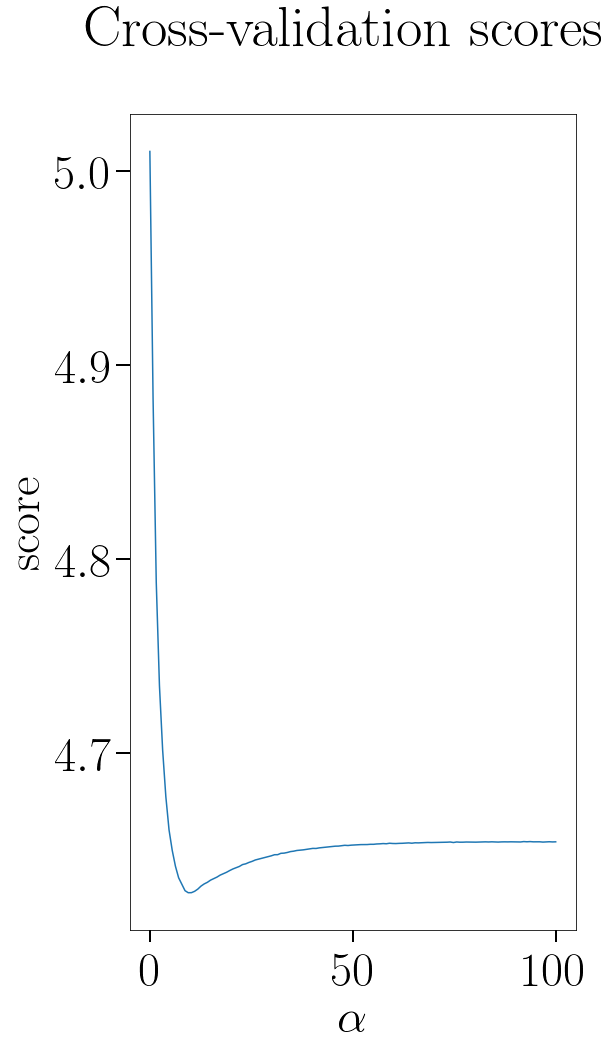

In [68]:
plot_cv_results(cv)

In [69]:
def best_params(cv):
    current_best_score = -1
    alpha = -1
    l1_ratio = -1
    for r in cv.result:
        if len(r['scores']) > 0:
            if current_best_score >= 0:
                if -np.mean(r['scores']) < current_best_score:
                    current_best_score = np.mean(r['scores'])
                    alpha = r['alpha']
                    l1_ratio = r['l1_ratio']
            else:
                current_best_score = -np.mean(r['scores'])
                alpha = r['alpha']
                l1_ratio = r['l1_ratio']
    return alpha, l1_ratio

In [70]:
alpha, l1_ratio = best_params(cv)
print("params: alpha={}, l1={}".format(alpha, l1_ratio))

params: alpha=9.448818897637796, l1=0


In [76]:
if os.path.exists(lasso_coefficients_fname):
#if False:
    rates = np.load(lasso_coefficients_fname)
else:
    system = set_up_system(train_initial_state)
    optsuite = sample_tools.Suite.from_trajectory(train_traj, system, get_bfc(), interp_degree=interp_degree, 
                                                  tol=tol, alpha=alpha, l1_ratio=l1_ratio, init_xi=init_rates)
    estimator = optsuite.get_estimator(verbose=True)
    estimator.fit(None)
    if estimator.success_:
        rates = estimator.coefficients_
        np.save(lasso_coefficients_fname, rates)
    else:
        rates = ":-("

max counts = 70.3, min nonzero counts = 30.0
optimization problem did exit successfully (alpha=9.44881889764, lambda=0)!
status 0: Optimization terminated successfully.
12 / 30000 iterations


In [77]:
print(init_rates)
print(rates)

[  3.75224068e-02   4.06393936e-02   9.62966129e-03   9.39506319e-05
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   2.45789760e-04   1.12495296e-02]
[  3.60017329e-03   0.00000000e+00   9.14416776e-03   8.71339246e-05
   0.00000000e+00   4.14940135e-11   0.00000000e+00   0.00000000e+00
   2.00475083e-11   0.00000000e+00   0.00000000e+00]


In [74]:
print(desired_rates)

[ 0.02    0.02    0.01    0.0001  0.0001  0.      0.      0.      0.      0.
  0.    ]


In [60]:
rrates = rates[:]
idx = np.where(rates <= 1e-8)
rrates[idx] = 0
print(rrates)

init_rrates = init_rates[:]
init_rrates[np.where(init_rrates <= 1e-8)] = 0
print(init_rrates)

[  3.59787499e-03   0.00000000e+00   9.14037898e-03   8.71497222e-05
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00]
[  3.75224068e-02   4.06393936e-02   9.62966129e-03   9.39506319e-05
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   2.45789760e-04   1.12495296e-02]


In [61]:
desired_rates

array([ 0.02  ,  0.02  ,  0.01  ,  0.0001,  0.0001,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ])

In [62]:
np.sum(rrates)

0.01282540368936853

In [63]:
#plot_results(train_traj, rrates, title='Estimated model', outfile=plot_expected_estimated_concentrations_fname)

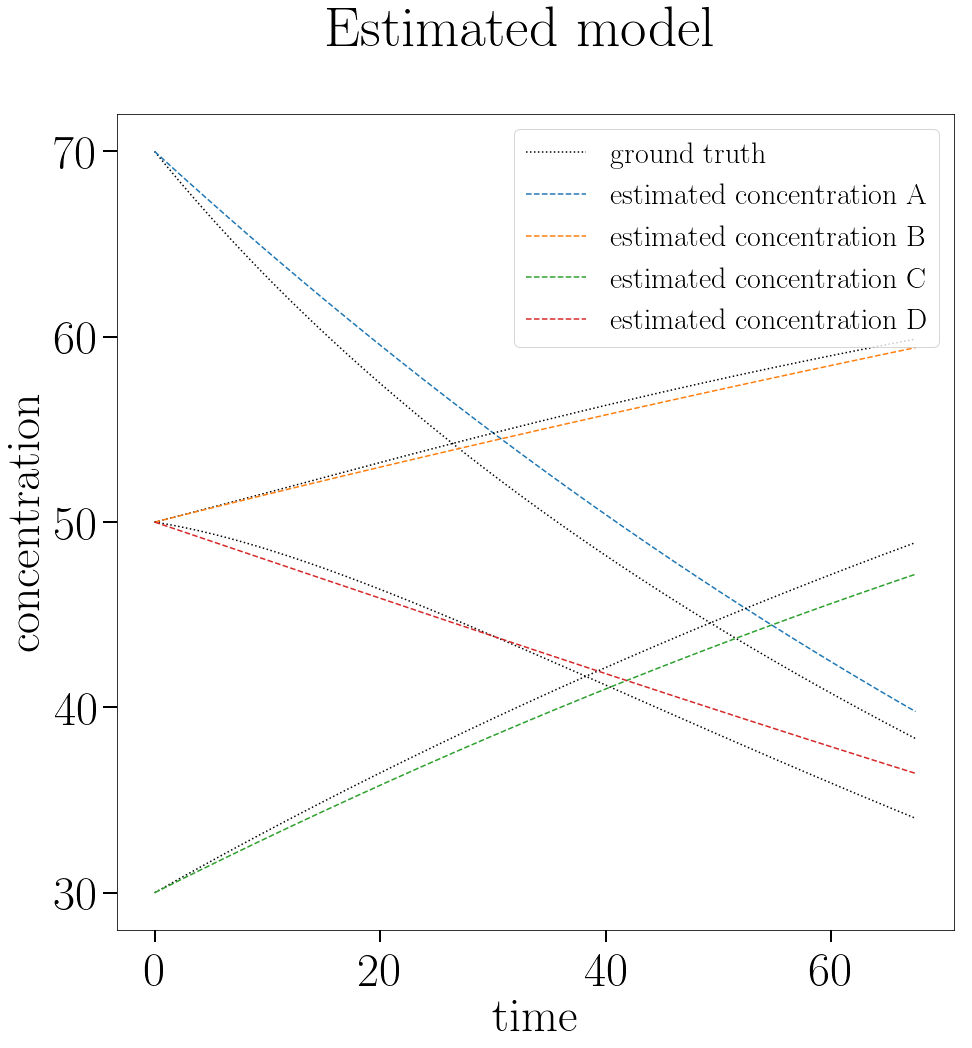

In [79]:
config = system.get_trajectory_config()
expected = sample_tools.Suite.estimated_behavior(desired_rates, get_bfc(), train_traj.counts[0], train_traj.times)
estimated = sample_tools.Suite.estimated_behavior(rrates, get_bfc(), train_traj.counts[0], train_traj.times)

fig, ax1 = plt.subplots(nrows=1, ncols=1)

fig.suptitle('Estimated model')
ax1.set_xlabel('time')
ax1.set_ylabel('concentration')
for t in config.types.keys():
    type_id = config.types[t]
    ax1.plot(train_traj.times, expected[:, type_id], "k:", label=None if type_id != 0 else 'ground truth')
    ax1.plot(train_traj.times, estimated[:, type_id], "--", label="estimated concentration " + t)
    # ax1.plot(train_traj.times, train_traj.counts[:, type_id], "k-")
ax1.legend(loc="upper right")
fig.savefig(plot_expected_estimated_concentrations_fname)